In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q transformers pytorch-lightning timm

In [3]:
import torch
from torch import nn
import torchvision
import numpy as np
import timm
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import operator
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import torchvision.transforms as transforms 
import seaborn as sns
import tqdm
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
import itertools

In [4]:
from transformers import ViTFeatureExtractor

In [5]:
data_directory = './'

In [6]:
torchvision.datasets.Flowers102(root=f'{data_directory}', download=True)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./
    split=train

In [7]:
image_size = 224
batch_size = 32
CHECKPOINT_PATH = ""

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [9]:
normalize = transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = transforms.Compose(
        [
            transforms.RandomResizedCrop(feature_extractor.size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    )

val_transforms = transforms.Compose(
        [
            transforms.Resize(feature_extractor.size),
            transforms.CenterCrop(feature_extractor.size),
            transforms.ToTensor(),
            normalize,
        ]
    )


In [10]:
class FlowerDataset(torchvision.datasets.Flowers102):
    
    def __getitem__(self, idx):
        images, labels = super().__getitem__(idx)
        labels -= 1
        return images, labels

In [11]:
training_set = FlowerDataset(root=f'{data_directory}', split='train', transform=train_transforms)
validation_set = FlowerDataset(root=f'{data_directory}', split='val', transform=val_transforms)
test_set = FlowerDataset(root=f'{data_directory}', split='test', transform=val_transforms)

print(f'Length of training data: {len(training_set)}')
print(f'Length of validation data: {len(validation_set)}')
print(f'Length of test data: {len(test_set)}')

Length of training data: 1020
Length of validation data: 1020
Length of test data: 6149


In [12]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                      shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,
                                      shuffle=False)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                        shuffle=False)

In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
gpus=0
if (device==torch.device('cuda:0')):
    gpus=1
print(gpus)

Device: cuda:0
1


In [14]:
id2label = {
    x : x for x in range(102)
}

In [15]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=102):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                             ignore_mismatched_sizes=True,
                                                              num_labels=num_labels,
                                                              id2label=id2label,
                                                              label2id=None)
        
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values, labels = batch
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)
        
        self.train_loss.append(loss)
        self.train_acc.append(accuracy)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)
        self.val_loss.append(loss)
        self.val_acc.append(accuracy)
        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=1e-4)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return validation_loader

    def test_dataloader(self):
        return test_loader

In [16]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping


model = ViTLightningModule()
trainer = Trainer(gpus=gpus, callbacks=[EarlyStopping(monitor='validation_loss')], max_epochs=50)
trainer.fit(model)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.7/site-pa

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
def predict(data_loader):

    running_correct = 0
    running_loss = 0.0
    total = 0

    num_batches = len(data_loader)

    criterion = nn.CrossEntropyLoss()

    for idx, (inputs, labels) in enumerate(data_loader):
        print(f'\rPredicting on batch {idx+1}/{num_batches}', end='')
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        running_loss += loss.item()
        total += inputs.shape[0]
        running_correct += torch.sum(preds == labels).item()

    print(f'\rLoss: {running_loss / num_batches:.4f}, Accuracy: {running_correct / total:.4f}')

In [18]:
def plot_curve(train_history, val_history, title='Model Accuracy', ylabel='Accuracy', legend_loc='upper left'):
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('steps')
    plt.legend(['train', 'validation'], loc=legend_loc)
    
    plt.show()

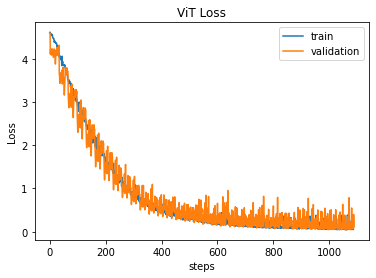

In [19]:
train_loss_np = [x.cpu().detach().numpy() for x in trainer.model.train_loss]
val_loss_np = [x.cpu().detach().numpy() for x in trainer.model.val_loss]
plot_curve(train_loss_np, val_loss_np, title='ViT Loss', ylabel='Loss', legend_loc='upper right')

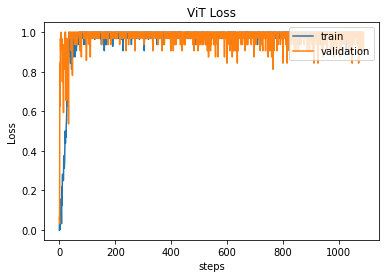

In [20]:
plot_curve(trainer.model.train_acc, trainer.model.val_acc, title='ViT Loss', ylabel='Loss', legend_loc='upper right')

In [21]:
model = model.to(device)

In [22]:
predict(train_loader)

Loss: 0.0802, Accuracy: 0.9961


In [23]:
predict(validation_loader)

Loss: 0.1816, Accuracy: 0.9725


In [24]:
predict(test_loader)

Loss: 0.2144, Accuracy: 0.9657


In [25]:
torch.save({
            'model_state_dict': model.state_dict(),
            }, 'vit-base-patch16-224-in21k.pth')